<a href="https://colab.research.google.com/github/danhorsley/DS-Unit-1-Sprint-4-Statistical-Tests-and-Experiments/blob/master/Copy_of_LS_DS_142_Sampling_Confidence_Intervals_and_Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [1]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [2]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=18.73117081585641, pvalue=8.562053506838777e-05)


In [3]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## Live Lecture - let's explore some more of scipy.stats

Candidate topics to explore:

- `scipy.stats.chi2` - the Chi-squared distribution, which we can use to reproduce the Chi-squared test
- Calculate the Chi-Squared test statistic "by hand" (with code), and feed it into `chi2`
- Build a confidence interval with `stats.t.ppf`, the t-distribution percentile point function (the inverse of the CDF) - we can write a function to return a tuple of `(mean, lower bound, upper bound)` that you can then use for the assignment (visualizing confidence intervals)

In [7]:
gender = ['male', 'male', 'male', 'female', 'female', 'female']
eats_outside = ['outside', 'inside', 'inside', 'inside', 'outside', 'outside']

import pandas as pd

df = pd.DataFrame({"gender": gender, "preference": eats_outside})
df.head(6)

,gender,preference
0,male,outside
1,male,inside
2,male,inside
3,female,inside
4,female,outside
5,female,outside


In [8]:
pd.crosstab(df.gender, df.preference)

preference,inside,outside
gender,,
female,1,2
male,2,1


In [0]:
table = pd.crosstab(df.gender, df.preference, margins=True)

In [19]:
df = df.replace("male", 0)
df = df.replace("female", 1)
df = df.replace('outside', 0)
df = df.replace('inside',1)

df.head()

,gender,preference
0,0,0
1,0,1
2,0,1
3,1,1
4,1,0


In [27]:
pd.crosstab(df.gender, df.preference, margins=True)

expected = [[1.5, 1.5],
            [1.5, 1.5]]

# Lets think about marginal proportions

# Let's just type out/explain the margin counts
# Total number of males (first row) = 3
# Total number of females (second row) = 3
# Total number of people who prefer outside = 3
# Total number of people who prefer inside = 3

# Marginal Proportion of the first row 
# obs / total = (3 males) / (6 humans)

pd.crosstab(df.gender, df.preference, margins=True, normalize='all')
observed = np.array([[.5,.5],
                     [.5,.5]])

deviation = numerator = observed - expected
print(numerator)

deviation_squared = deviation**2
print("deviation squared \n", deviation_squared)

fraction = (deviation_squared / expected) 
print("fraction: \n", fraction)

chi2 = fraction.sum()
print(chi2/4)

[[-1. -1.]
 [-1. -1.]]
deviation squared 
 [[1. 1.]
 [1. 1.]]
fraction: 
 [[0.66666667 0.66666667]
 [0.66666667 0.66666667]]
0.6666666666666666


In [28]:
expected_values = [[1.5, 1.5], [1.5, 1.5]]
deviation = (((.5)**2) / 1.5) * 4  # 0.5^2 deviation per cell, scaled and added
print(deviation)

0.6666666666666666


In [29]:
chi_data = [[1,2],
            [2,1]]

from scipy.stats import chisquare  # One-way chi square test

chisquare(chi_data, axis=None)

Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)

In [33]:
from scipy.stats import chi2_contingency

# table = [[1,2],[2,4]]

chi2statistic, pvalue, dof, observed = chi2_contingency(table)

print("chi2 stat", chi2statistic)
print("p-value", pvalue)
print('degrees of freedom', dof)
print("Contingency Table: \n", observed)

chi2 stat 0.6666666666666666
p-value 0.9553750807650524
degrees of freedom 4
Contingency Table: 
 [[1.5 1.5 3. ]
 [1.5 1.5 3. ]
 [3.  3.  6. ]]


In [31]:
def lazy_chisquare(observed, expected):
  chisquare = 0
  for row_obs, row_exp in zip(observed, expected):
    for obs, exp in zip(row_obs, row_exp):
      chisquare += (obs - exp)**2 / exp
  return chisquare

chi_data = [[1, 2], [2, 1]]
expected_values = [[1.5, 1.5], [1.5, 1.5]]
chistat = lazy_chisquare(chi_data, expected_values)
chistat

0.6666666666666666

# Confidence Intervals

In [0]:
# Confidence intervals!
# Similar to hypothesis testing, but centered at sample mean
# Generally better than reporting the "point estimate" (sample mean)
# Why? Because point estimates aren't always perfect

import numpy as np
from scipy import stats

def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2., n - 1)
  return (mean, mean - interval, mean + interval)

def report_confidence_interval(confidence_interval):
  """
  Return a string with a pretty report of a confidence interval.
  
  Arguments:
    confidence_interval - tuple of (mean, lower bound, upper bound)
  
  Returns:
    None, but prints to screen the report
  """
  #print('Mean: {}'.format(confidence_interval[0]))
  #print('Lower bound: {}'.format(confidence_interval[1]))
  #print('Upper bound: {}'.format(confidence_interval[2]))
  s = "our mean lies in the interval [{:.2}, {:.2}]".format(
      confidence_interval[1], confidence_interval[2])
  return s

In [42]:
#conf int = [lower_bound]

coinflips = np.random.binomial(n=1,p=0.9, size = 100)
print(coinflips)

[1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1]


In [37]:
import scipy.stats as stats
stats.ttest_1samp(coinflips,0.5)

Ttest_1sampResult(statistic=2.902046691560975, pvalue=0.004569711972063771)

In [43]:
coinflip_interval = confidence_interval(coinflips)  # Default 95% conf
coinflip_interval

(0.94, 0.8926400636260718, 0.987359936373928)

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):

1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

In [4]:
#stealing my code from yesterday
from google.colab import files
uploaded = files.upload()
import pandas as pd
import numpy as np
df = pd.read_csv('house-votes-84.txt',header = None)
df = df.rename(index=str,columns={0: "Party"})
for col in range(1,17):
  df[col] = np.where(df[col]=='y',1,df[col])
  df[col] = np.where(df[col]=='n',0,df[col])
# i had to use that replace so as not to change n in republican

df_rep = df[df['Party']=='republican'].copy()
df_dem = df[df['Party']=='democrat'].copy()

df_rep = df_rep.replace('?',np.nan)
df_dem = df_dem.replace('?',np.nan)
rep_vote_means = [round(df_rep[col].mean(),0) for col in range(1,17)]
dem_vote_means = [round(df_dem[col].mean(),0) for col in range(1,17)]

for i in range (1,17):
  df_rep[i] = np.where(df_rep[i].isna(),rep_vote_means[i-1],df_rep[i])
  

for i in range (1,17):
  df_dem[i] = np.where(df_dem[i].isna(),dem_vote_means[i-1],df_dem[i])
  
df_clean = df_rep.append(df_dem)

Saving house-votes-84.txt to house-votes-84.txt


In [0]:
df_rep = df_rep.drop(['Party'],axis=1)

In [0]:
df_dem = df_dem.drop(['Party'],axis=1)

In [47]:
df_clean.head().drop(['Party'],axis=1)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
1,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
7,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
8,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
10,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [62]:
#taking a look at combined voting record for one column confidence interval
confidence_interval(df_clean[1])

(0.45057471264367815, 0.40363355738441686, 0.49751586790293945)

In [71]:
#now looking at confidence intervals for all combined voting record:
combined_ci = []
for col in df_clean.columns:
  aaa = confidence_interval(df_clean[col])
  combined_ci.append(aaa)
  print(confidence_interval(df_clean[col]))
  

(0.45057471264367815, 0.40363355738441686, 0.49751586790293945)
(0.5586206896551724, 0.5117738240522927, 0.6054675552580522)
(0.5977011494252874, 0.5514382885440262, 0.6439640103065486)
(0.41379310344827586, 0.3673273343087576, 0.46025887258779413)
(0.4942528735632184, 0.44708379875190496, 0.5414219483745318)
(0.6298850574712643, 0.5843322648097936, 0.675437850132735)
(0.5678160919540229, 0.5210798068623532, 0.6145523770456927)
(0.5655172413793104, 0.5187517778633032, 0.6122827048953176)
(0.5195402298850574, 0.47240407521836925, 0.5666763845517456)
(0.503448275862069, 0.4562772066288688, 0.5506193450952691)
(0.3724137931034483, 0.3268032106405461, 0.41802437556635047)
(0.42298850574712643, 0.37637920797146, 0.46959780352279284)
(0.503448275862069, 0.4562772066288688, 0.5506193450952691)
(0.5862068965517241, 0.5397411274122058, 0.6326726656912424)
(0.4367816091954023, 0.3899879906717175, 0.4835752277190871)
(0.8574712643678161, 0.8244892597443997, 0.8904532689912324)


In [72]:
#now looking for individual party voting records
rep_ci = []
for col in df_rep.columns:
  bbb = confidence_interval(df_rep[col])
  rep_ci.append(bbb)
  print(confidence_interval(df_rep[col]))


(0.18452380952380953, 0.12526125471665267, 0.2437863643309664)
(0.5654761904761905, 0.4897471468537114, 0.6412052340986696)
(0.13095238095238096, 0.07941444662385228, 0.18249031528090964)
(0.9880952380952381, 0.9715257809044495, 1.0046646952860268)
(0.9523809523809523, 0.9198464458225006, 0.984915458939404)
(0.8988095238095238, 0.8527359210232621, 0.9448831265957855)
(0.23214285714285715, 0.16764186452309232, 0.296643849762622)
(0.14285714285714285, 0.08939749343905154, 0.19631679227523416)
(0.1130952380952381, 0.06471041314631555, 0.16148006304416063)
(0.5654761904761905, 0.4897471468537114, 0.6412052340986696)
(0.125, 0.07447485666781078, 0.17552514333218922)
(0.8809523809523809, 0.831477461593508, 0.9304273003112539)
(0.8690476190476191, 0.8175096847190904, 0.9205855533761478)
(0.9821428571428571, 0.9619107163315306, 1.0023749979541836)
(0.08333333333333333, 0.04110892062782448, 0.12555774603884218)
(0.7023809523809523, 0.6325311397787999, 0.7722307649831047)


In [73]:
#now looking for individual party voting records
dem_ci = []
for col in df_dem.columns:
  ccc = confidence_interval(df_dem[col])
  dem_ci.append(ccc)
  print(confidence_interval(df_dem[col]))

(0.6179775280898876, 0.5593207017612246, 0.6766343544185506)
(0.5543071161048689, 0.4943030277521611, 0.6143112044575767)
(0.8913857677902621, 0.8538224468450312, 0.9289490887354931)
(0.052434456928838954, 0.025525257217451757, 0.07934365664022615)
(0.20599250936329588, 0.1571693613158776, 0.25481565741071416)
(0.4606741573033708, 0.40049996006382055, 0.5208483545429211)
(0.7790262172284644, 0.7289381611781973, 0.8291142732787316)
(0.8314606741573034, 0.7862689149634521, 0.8766524333511547)
(0.7752808988764045, 0.7248917176706724, 0.8256700800821366)
(0.46441947565543074, 0.4042113143124596, 0.5246276369984019)
(0.5280898876404494, 0.4678240312506821, 0.5883557440302167)
(0.1348314606741573, 0.09359952308889968, 0.17606339825941492)
(0.27340823970037453, 0.21960123724933478, 0.3272152421514143)
(0.33707865168539325, 0.28001173722974465, 0.39414556614104185)
(0.6591760299625468, 0.6019552815869864, 0.7163967783381071)
(0.9550561797752809, 0.9300448249904457, 0.9800675345601161)


In [0]:
#this is basically saying for vote 4 for example if we picked 100 republican voters a large number of times, 95% of the time
# between 97 and 100 would vote for the bill

In [74]:
combined_ci[0]

(0.45057471264367815, 0.40363355738441686, 0.49751586790293945)

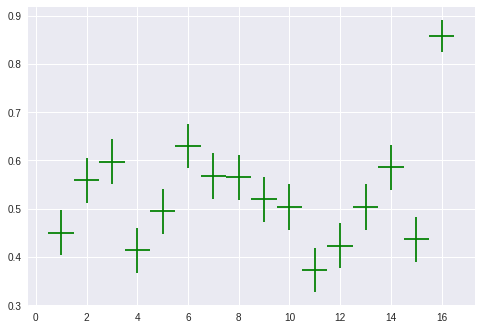

In [83]:
#df_clean = df_clean.drop(['Party'],axis=1)

clean_mean = [combined_ci[i][0] for i in range(0,len(combined_ci))]
clean_err = [(combined_ci[i][0]-combined_ci[i][1]) for i in range(0,len(combined_ci))]

plt.errorbar(df_clean.columns, clean_mean, xerr=0.5, yerr=clean_err, linestyle='',color='g')
plt.show()



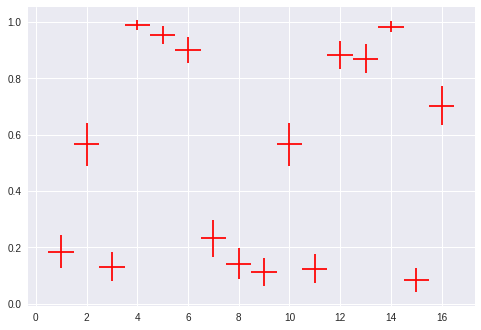

In [84]:
rep_mean = [rep_ci[i][0] for i in range(0,len(rep_ci))]
rep_err = [(rep_ci[i][0]-rep_ci[i][1]) for i in range(0,len(rep_ci))]

plt.errorbar(df_rep.columns, rep_mean, xerr=0.5, yerr=rep_err, linestyle='',color='r')
plt.show()

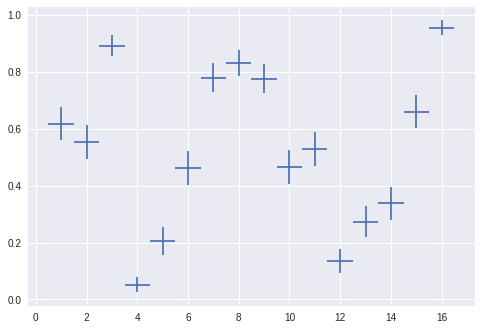

In [81]:
dem_mean = [dem_ci[i][0] for i in range(0,len(dem_ci))]
dem_err = [(dem_ci[i][0]-dem_ci[i][1]) for i in range(0,len(dem_ci))]

plt.errorbar(df_dem.columns, dem_mean, xerr=0.5, yerr=dem_err, linestyle='')
plt.show()

In [0]:
#you can see the voting record for each party indiviually is much more polarised on many votes with a tight confidence interval

In [0]:
# you can also see that the republicans only were more evenly split on 3 votes, while the democrats were evenly split on 7 votes
#though this sample size of 16 votes is not large enough to draw any conclusions from that

In [0]:
#the confidence intervals tell you for some votes there was very little intra-party divergence - i.e. vote 4 for both parties, vote 14 for the
#republicans and vote 16 for the dems

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)

In [0]:
# ignore the below - was just messing around with a few examples

In [6]:
#messing around witi stats examples
import numpy as np
from scipy import stats
N = 10000
a = np.random.normal(0, 1, N)
mean, sigma = a.mean(), a.std(ddof=1)
conf_int_a = stats.norm.interval(0.68, loc=mean, scale=sigma)

print('{:0.2%} of the single draws are in conf_int_a'
      .format(((a >= conf_int_a[0]) & (a < conf_int_a[1])).sum() / float(N)))

M = 1000
b = np.random.normal(0, 1, (N, M)).mean(axis=1)
conf_int_b = stats.norm.interval(0.68, loc=0, scale=1 / np.sqrt(M))
print('{:0.2%} of the means are in conf_int_b'
      .format(((b >= conf_int_b[0]) & (b < conf_int_b[1])).sum() / float(N)))

67.44% of the single draws are in conf_int_a
68.15% of the means are in conf_int_b


In [17]:
#trying binomial distribution
NN = 10000
aaa = np.random.binomial(100, 0.25,NN)
mean, sigma = aaa.mean(), aaa.std(ddof=1)
conf_int_aaa = stats.norm.interval(0.68, loc=mean, scale=sigma)

print('{:0.2%} of the single draws are in conf_int_a'
      .format(((aaa >= conf_int_aaa[0]) & (aaa < conf_int_aaa[1])).sum() / float(NN)))

70.88% of the single draws are in conf_int_a


In [15]:
aaa

array([22, 25, 31, ..., 31, 26, 26])

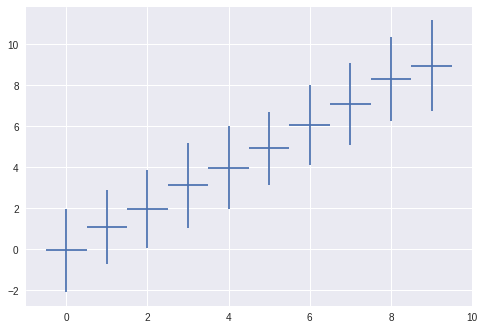

In [45]:
import matplotlib.pyplot as plt
df = pd.DataFrame()
df['category'] = np.random.choice(np.arange(10), 1000, replace=True)
df['number'] = np.random.normal(df['category'], 1)

mean = df.groupby('category')['number'].mean()
std = df.groupby('category')['number'].std()

plt.errorbar(mean.index, mean, xerr=0.5, yerr=2*std, linestyle='')
plt.show()

In [46]:
df.head()

,category,number
0,0,1.149602
1,7,5.524046
2,9,10.955054
3,5,5.249363
4,4,5.406332
